In [161]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from collections import Counter
from matplotlib.colors import LogNorm

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 10]

pd.options.mode.chained_assignment = None

In [162]:
# Load CSV file into Dataframe
sf_data = pd.read_csv('../../../DataScience/Crime/SFPD_Crime.csv')

# Data Wrangling

In [163]:
sf_data.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [164]:
# Removing out of range coordiantes
# Y max has coordinates of 90 when max should be 38
outliers = (sf_data['Y'] <= 38) & (sf_data['Y'] >= 37)
sf_data = sf_data[outliers]

In [165]:
# Find any NAN cells
sf_data.isnull().any()

IncidntNum    False
Category      False
Descript      False
DayOfWeek     False
Date          False
Time          False
PdDistrict     True
Resolution    False
Address       False
X             False
Y             False
Location      False
PdId          False
dtype: bool

In [166]:
sf_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2123168 entries, 0 to 2123310
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 226.8+ MB


In [167]:
# How many NAN values
sf_data.isnull().sum().sum()

1

In [168]:
# Current shape
sf_data.shape

(2123168, 13)

In [169]:
# Drop NAN cell & new shape
sf_data = sf_data.dropna()
sf_data.shape

(2123167, 13)

In [170]:
# Split data up into by year
sf_data['Date'] = pd.to_datetime(sf_data['Date'])

In [171]:
test = pd.DataFrame(sf_data['Date'])
test.columns = ['Date']
test['Date'] = test['Date'].dt.strftime('%Y')

In [172]:
test['Date'].unique()

array(['2015', '2016', '2014', '2017', '2005', '2011', '2009', '2004',
       '2003', '2007', '2012', '2006', '2008', '2013', '2010'], dtype=object)

In [173]:
sf_data_2003 = sf_data.loc[sf_data['Date'].dt.year == 2003]
sf_data_2004 = sf_data.loc[sf_data['Date'].dt.year == 2004]
sf_data_2005 = sf_data.loc[sf_data['Date'].dt.year == 2005]
sf_data_2006 = sf_data.loc[sf_data['Date'].dt.year == 2006]
sf_data_2007 = sf_data.loc[sf_data['Date'].dt.year == 2007]
sf_data_2008 = sf_data.loc[sf_data['Date'].dt.year == 2008]
sf_data_2009 = sf_data.loc[sf_data['Date'].dt.year == 2009]
sf_data_2010 = sf_data.loc[sf_data['Date'].dt.year == 2010]
sf_data_2011 = sf_data.loc[sf_data['Date'].dt.year == 2011]
sf_data_2012 = sf_data.loc[sf_data['Date'].dt.year == 2012]
sf_data_2013 = sf_data.loc[sf_data['Date'].dt.year == 2013]
sf_data_2014 = sf_data.loc[sf_data['Date'].dt.year == 2014]
sf_data_2015 = sf_data.loc[sf_data['Date'].dt.year == 2015]
sf_data_2016 = sf_data.loc[sf_data['Date'].dt.year == 2016]
sf_data_2017 = sf_data.loc[sf_data['Date'].dt.year == 2017]

In [174]:
test_list = []
test_list.append((sf_data_2003, '2003'))
test_list.append((sf_data_2004, '2004'))
test_list.append((sf_data_2005, '2005'))
test_list.append((sf_data_2006, '2006'))
test_list.append((sf_data_2007, '2007'))
test_list.append((sf_data_2008, '2008'))
test_list.append((sf_data_2009, '2009'))
test_list.append((sf_data_2010, '2010'))
test_list.append((sf_data_2011, '2011'))
test_list.append((sf_data_2012, '2012'))
test_list.append((sf_data_2013, '2013'))
test_list.append((sf_data_2014, '2014'))
test_list.append((sf_data_2015, '2015'))
test_list.append((sf_data_2016, '2016'))
test_list.append((sf_data_2017, '2017'))

In [175]:
def generate_heatmap_list(data_set_list):
    """
        This function will generate a heapmap of SF given a dataframe with X & Y coordinates.
    """
    
    fig = plt.figure(figsize=(15,40))
    
    for count in range(len(data_set_list)):
        date_year = data_set_list[count][1]
        title = date_year + " SF Crime Rate Heatmap"

        data_set = data_set_list[count][0]

        # Assign SF DF series to sf_location
        location = data_set[['X', 'Y']]

        # Load SF city image
        sf_img = plt.imread('../Img/SF.png')

        # Create heatmap of SF City
        fig.add_subplot(8,2,count+1)
        plt.hist2d(location['X'], location['Y'], bins=50, cmap='hot', vmin=0, vmax=4500)
        plt.colorbar()
        plt.imshow(sf_img, extent=[location['X'].min(), location['X'].max(),
                                   location['Y'].min(), location['Y'].max()], alpha=.225)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [176]:
def generate_heatmap(data_set, title):
    """
        This function will generate a heapmap of SF given a dataframe with X & Y coordinates.
    """
    
    # Assign SF DF series to sf_location
    location = data_set[['X', 'Y']]
        
    # Load SF city image
    sf_img = plt.imread('../Img/SF.png')
    
    # Create heatmap of SF City
    plt.hist2d(data_set['X'], data_set['Y'], bins=100, cmap='hot', norm=LogNorm())
    plt.colorbar()
    plt.imshow(sf_img, extent=[location['X'].min(), location['X'].max(),
                               location['Y'].min(), location['Y'].max()], alpha=.4)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

In [177]:
test_df = sf_data_2016.copy()

step = .002
to_bin = lambda x: np.floor(x / step) * step
test_df['latbin'] = test_df.X.map(to_bin)
test_df['lonbin'] = test_df.Y.map(to_bin)
groups = test_df.groupby(("latbin", "lonbin"))

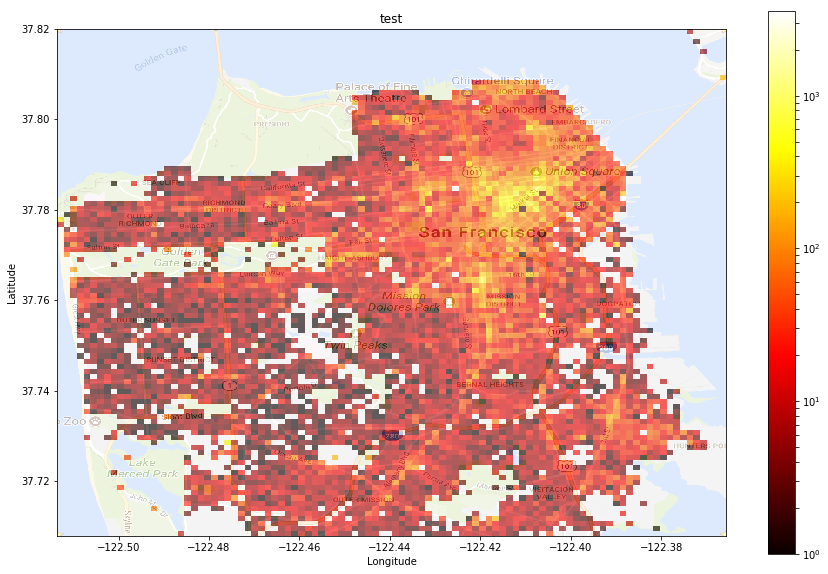

In [178]:
generate_heatmap(sf_data_2016, "test")

# SF Crime Rate 03-17 Heatmap

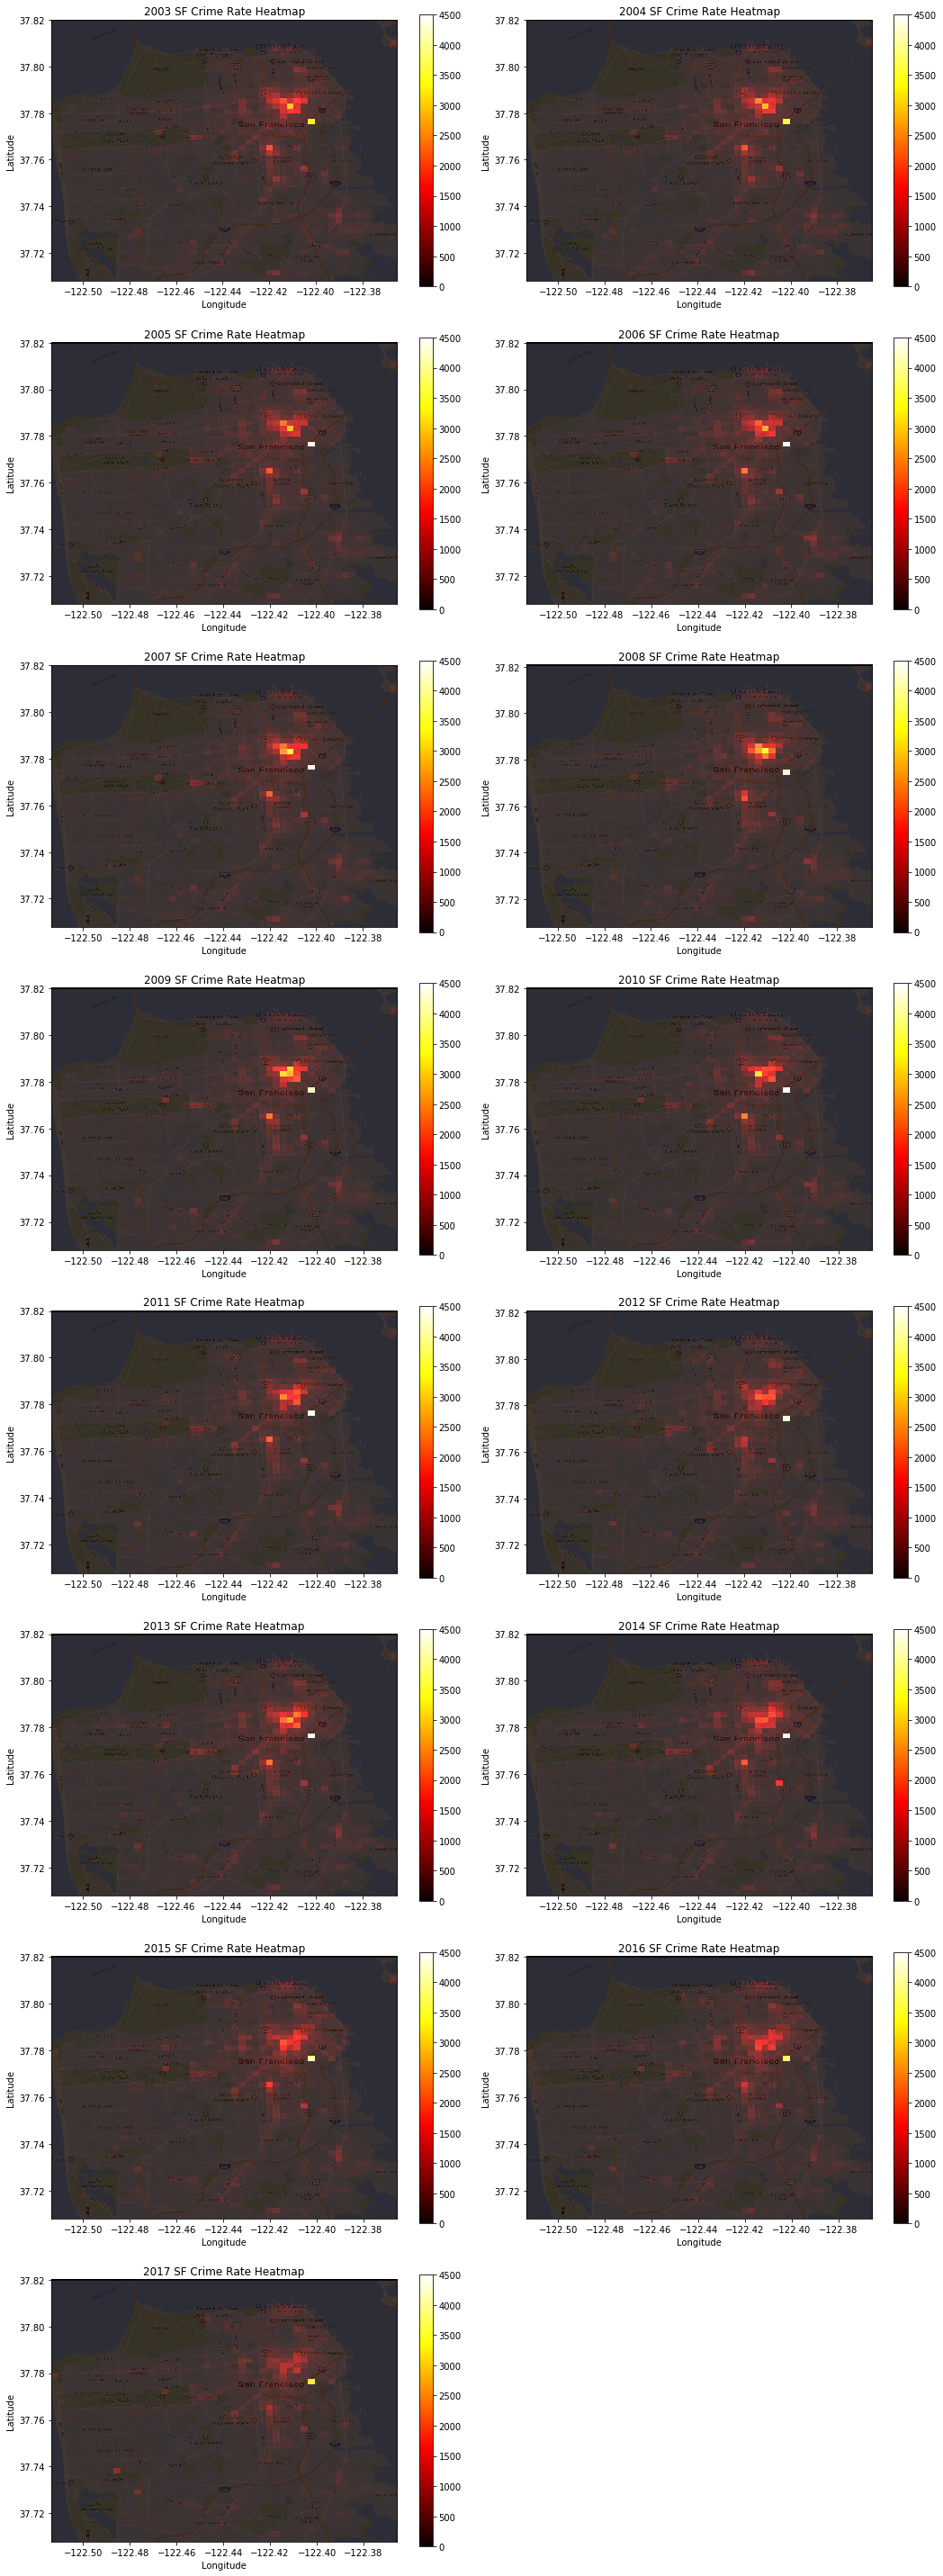

In [179]:
generate_heatmap_list(test_list)

# SF Crime Rate 2016 Heatmap Split
* Split evenly to 9 region
* Zoom into each region


In [180]:
def grid_coordinates(data_set, size):
    """
        This function will generate a grid map of a given data set and total size X*Y = size
    """
    
    # Get Max and Min of the coordinates
    x_max, y_max = data_set.drop_duplicates().max()
    x_min, y_min = data_set.drop_duplicates().min()
    
    size = int(math.sqrt(size))

    # Find increment to split the map
    x_inc = (x_max - x_min) / size
    y_inc = (y_max - y_min) / size

    # Splitting map into 9 grids and store range in an array
    # 0 1 2
    # 3 4 5
    # 6 7 8

    # Empty grid
    grid = []

    # Assign max y coordinate to mover var
    y_move = y_max

    # Iterate through ranges y axis is the outside loop
    for y_loop in range(size):
        x_move = x_min
        y_move = y_move - y_inc 

        # Iterate through the x ranges
        for x_loop in range(size):
            x_move = x_move + x_inc
            grid.append([x_move, y_move])   
    
    # Return grid coordiantes and size of map
    return (grid, size)

In [181]:
grid, size = grid_coordinates(sf_data_2016[['X', 'Y']], 9)

In [182]:
for x in range(len(grid)):
    print(grid[x])

[-122.46428318462766, 37.782624296017538]
[-122.41492430499032, 37.782624296017538]
[-122.36556542535298, 37.782624296017538]
[-122.46428318462766, 37.745273099738071]
[-122.41492430499032, 37.745273099738071]
[-122.36556542535298, 37.745273099738071]
[-122.46428318462766, 37.707921903458605]
[-122.41492430499032, 37.707921903458605]
[-122.36556542535298, 37.707921903458605]


In [183]:
# Declare coordiantes
y_max = sf_data_2016['Y'].max()
y = grid[0][1]

# Iterate through row section of the grid
for row in range(size):
    
    # Assign the min range for X coordinates
    x_min = sf_data_2016['X'].min()
    
    # If not first iteration, adjust the y coordinates
    if(row != 0):
        try:
            y_max = grid[(row * size) - 1][1]
            y     = grid[((row + 1) * size) - 1][1]
        except IndexError:
            y     = grid[-1][1]
    
    # Iterate through column section of the gride
    for col in range(size):
        
        # Set X position
        x = grid[col][0]
        
        # Boolean operation to check if any points lay inside the gride
        test = ((sf_data_2016['X'] > x_min) &
                (sf_data_2016['X'] < x) &
                (sf_data_2016['Y'] < y_max) &
                (sf_data_2016['Y'] > y)      
        )

        # Shift our limit over to the next grid
        x_min = x
        
        # Assign booleam operation and create a new dataframe for the each grid
        test_df = sf_data_2016[test]
        print('{} : {}'.format(col, len(test_df)))

0 : 846
1 : 20369
2 : 28488
0 : 8587
1 : 35529
2 : 28777
0 : 5445
1 : 11293
2 : 11053


# Crime By Area


In [330]:
url = "https://statisticalatlas.com/neighborhood/California/San-Francisco/Mission/Population#figure/neighborhood-in-san-francisco/total-population"
district_name = []
district_pop = []


# Package url and send request to r
r = requests.get(url)

# Turn package into html text
html_doc = r.text

# Create soup
soup = BeautifulSoup(html_doc, 'html.parser')

# Locate div of interest
mydivs = soup.find("div", class_="figure-contents")
a_in_divs = mydivs.find_all('a')
g_in_divs = mydivs.find_all('g')

# Iterate through g tags and scrap population number
for g in g_in_divs[3:]:
    size = g.title.text.replace(',', '').split('.')
    district_pop.append(int(size[0]))

# Iterate through a tags and scrap district names
for a in a_in_divs:
    city_name = a.title.text.split(' Neighborhood')[:-1]
    district_name.append(city_name[0])
    
for count, x in enumerate(district_name):
    print("{} : {}".format(district_name[count], district_pop[count]))

Mission : 55383
Western Addition : 51202
Outer Sunset : 47461
Downtown : 42897
South Of Market : 39911
Excelsior : 38304
Outer Richmond : 36439
Inner Richmond : 35334
Bayview : 33994
Ocean View : 28674
Parkside : 27857
Outer Mission : 27404
Bernal Heights : 25935
Inner Sunset : 25317
Visitacion Valley : 23689
Nob Hill : 21896
Haight-Ashbury : 21376
Marina : 21237
West Of Twin Peaks : 20295
Castro-Upper Market : 19816
Lakeshore : 19581
Pacific Heights : 19024
Noe Valley : 18928
Russian Hill : 17579
Crocker Amazon : 13253
Potrero Hill : 12440
North Beach : 12243
Chinatown : 9998
Presidio Heights : 7767
Twin Peaks : 6972
Glen Park : 6462
Financial District : 6159
Diamond Heights : 2452
Seacliff : 1759


In [314]:
district = {'richmond'   : ['Outer Richmond', 'Inner Richmond', 'Presidio Heights', 'Seacliff'],
            'taraval'    : ['Outer Sunset', 'Parkside', 'Inner Sunset', 'Lakeshore'],
            'park'       : ['Haight-Ashbury', 'West Of Twin Peaks', 'Castro-Upper Market', 'Twin Peaks', 'Diamond Heights'],
            'northern'   : ['Western Addition', 'Marina', 'Pacific Heights', 'Noe Valley'],
            'central'    : ['Downtown', 'Nob Hill', 'Russian Hill', 'North Beach', 'Financial District'],
            'tenderloin' : ['Chinatown'],
            'sourthern'  : ['South Of Market'],
            'mission'    : ['Mission'],
            'ingleside'  : ['Ocean View', 'Outer Mission', 'Bernal Heights', 'Visitacion Valley', 'Crocker Amazon', 'Glen Park'],
            'bayveiw'    : ['Excelsior', 'Bayview', 'Potrero Hill']
             }

In [328]:
# Create a population dict
pop_dictionary = {}
temp = 0

# Iterate through list of names and keeping a counter
for count, name in enumerate(district_name):
    
    # Iterate through dictionary for evaluation
    for key, value in district.items():
        
        # Iterate through dictionary value list
        for index in value:
            
            # if dictionary value matches list value we will assign population size into a population dictio
            if(name == index):
                if(key in pop_dictionary):
                    temp = pop_dictionary[key]
                    pop_dictionary[key] = (temp + district_pop[count])
                else:
                    pop_dictionary[key] = district_pop[count]
                

{'mission': 55383, 'northern': 110391, 'taraval': 120216, 'central': 100774, 'sourthern': 39911, 'bayveiw': 84738, 'richmond': 81299, 'ingleside': 125417, 'park': 70911, 'tenderloin': 9998}


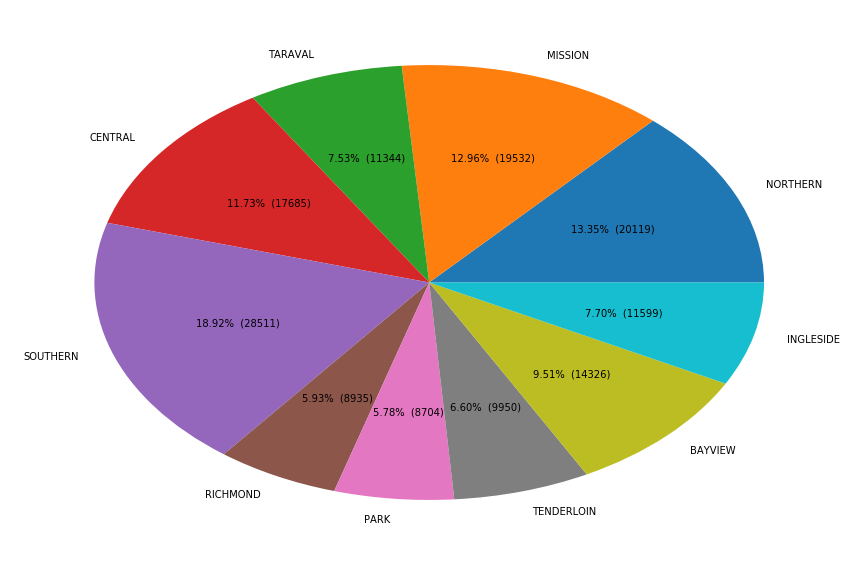

In [295]:
# Create new df
area_count = Counter(sf_data_2016['PdDistrict'])

# Formate pie chart function
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# create pie chart
plt.pie([float(v) for v in area_count.values()], 
        labels=[k for k in area_count], 
        autopct=make_autopct(area_count.values()))

plt.show()

# Resolved & Unresolved Crimes

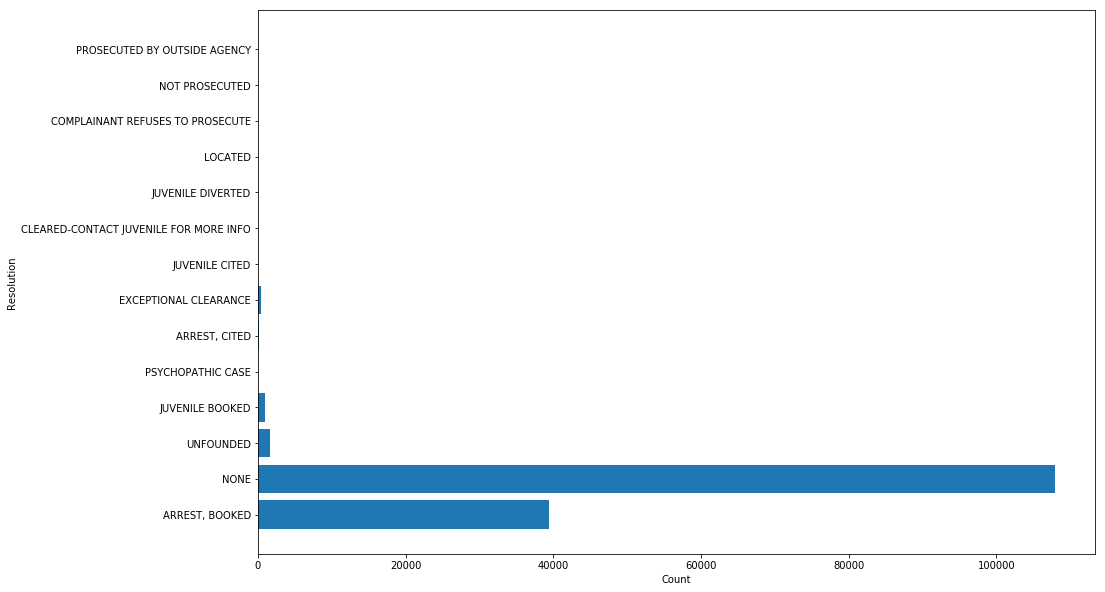

,Count
NONE,107944
"ARREST, BOOKED",39473
UNFOUNDED,1612
JUVENILE BOOKED,1036
EXCEPTIONAL CLEARANCE,371
"ARREST, CITED",144
CLEARED-CONTACT JUVENILE FOR MORE INFO,58
NOT PROSECUTED,22
LOCATED,20
PSYCHOPATHIC CASE,17


In [185]:
# Count the incidents by resolutions
resolution_df = Counter(sf_data_2016['Resolution'])

# Create df and assign count column
resolution_df = pd.DataFrame.from_dict(resolution_df, orient='index')
resolution_df.columns = ['Count']

# Create points for barh
res   = resolution_df.index.tolist()
y_pos = np.arange(len(resolution_df))
x_pos = resolution_df['Count'].tolist()

# Create barh graph
ax = plt.barh(y_pos, x_pos)
plt.xlabel('Count')
plt.ylabel('Resolution')
plt.yticks(y_pos, res)

plt.show()
resolution_df.sort_values('Count', ascending=False)

# Crime Rate Per Year

### Mean / Standard Error

In [186]:
def mean_std_err(dataset):
    """
        This function will calculate the mean, std dev, and std error
        Return: std_err
    """
    
    total_crime_count = 0

    # Iterate throught Counter to get total crime
    for x in dataset:
        total_crime_count += sf_day_count[x]

    # Mean of crimes
    crime_count_mean = math.ceil(total_crime_count / len(dataset))

    sum_of_sqaure = []

    # Devation from the mean and then squared
    for x in dataset:
        sum_of_sqaure.append((crime_count_mean - dataset[x])**2)

    # Sum squared and divide by sample size - 1
    sum_minus_sample_size = sum(sum_of_sqaure)/(len(dataset) - 1)
    
    # Standard devation : sqrt of sum minus sample size - 1
    std_dev = math.sqrt(sum_minus_sample_size)
    
    # Standard error: std_dev / sqrt(n)
    std_err = std_dev / math.sqrt(len(dataset))
    
    return (std_err, crime_count_mean)
    


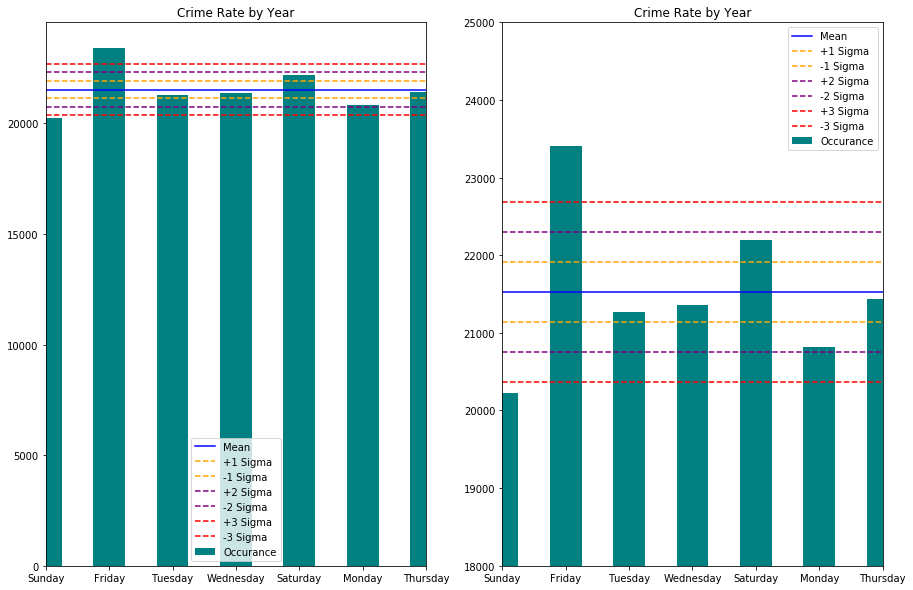

In [187]:
## This section helps us determine which days of the week is crimee occurs the most

# Assign DayOfWeek series to a Counter
sf_day_count = Counter(sf_data_2016['DayOfWeek'])

# Call mean_std_err function
std_err, mean = mean_std_err(sf_day_count)

# Broadcast new columns
df = pd.DataFrame.from_dict(sf_day_count, orient='index')
df.columns = ['Occurance']
df['Mean'] = mean
df['Std Error'] = std_err
df['+1 Sigma'] = mean + std_err
df['-1 Sigma'] = mean - std_err
df['+2 Sigma'] = mean + (std_err * 2)
df['-2 Sigma'] = mean - (std_err * 2)
df['+3 Sigma'] = mean + (std_err * 3)
df['-3 Sigma'] = mean - (std_err * 3)

# Plot frequency in terms of days
ax = plt.subplot(1,2,1)
df['Occurance'].plot.bar(title='Crime Rate by Year', color="teal", ax=ax)
df['Mean'].plot(kind='line', color='blue', ax=ax)
df[['+1 Sigma', '-1 Sigma']].plot(kind='line', linestyle='--', color='orange', ax=ax)
df[['+2 Sigma', '-2 Sigma']].plot(kind='line', linestyle='--', color='purple', ax=ax)
df[['+3 Sigma', '-3 Sigma']].plot(kind='line', linestyle='--', color='red', ax=ax)
plt.legend()

# Plot zoomed in view
ax1 = plt.subplot(1,2,2)
df['Occurance'].plot.bar(title='Crime Rate by Year', color="teal", ax=ax1, ylim=(18000, 25000))
df['Mean'].plot(kind='line', color='blue', ax=ax1)
df[['+1 Sigma', '-1 Sigma']].plot(kind='line', linestyle='--', color='orange', ax=ax1)
df[['+2 Sigma', '-2 Sigma']].plot(kind='line', linestyle='--', color='purple', ax=ax1)
df[['+3 Sigma', '-3 Sigma']].plot(kind='line', linestyle='--', color='red', ax=ax1)
plt.legend()

plt.show()


# Hypothesis Testing for Crime Rate
Null Hypothesis:  μ = 21528 rate per year <br/>
Alternative         : μ ≠ 21528 rate per year

# Crime Rate by the Hour (Year 2016)

In [188]:
## This section helps us determine the frequency of crime rate by the hour
    
# Assign SF DF time series into a list
sf_time = list(sf_data_2016['Time'])
sf_time_list = []

# Formate time list and append to sf_time_list
for time in sf_time:
    time_dt = datetime.strptime(time, '%H:%M')
    sf_time_list.append(time_dt.time())

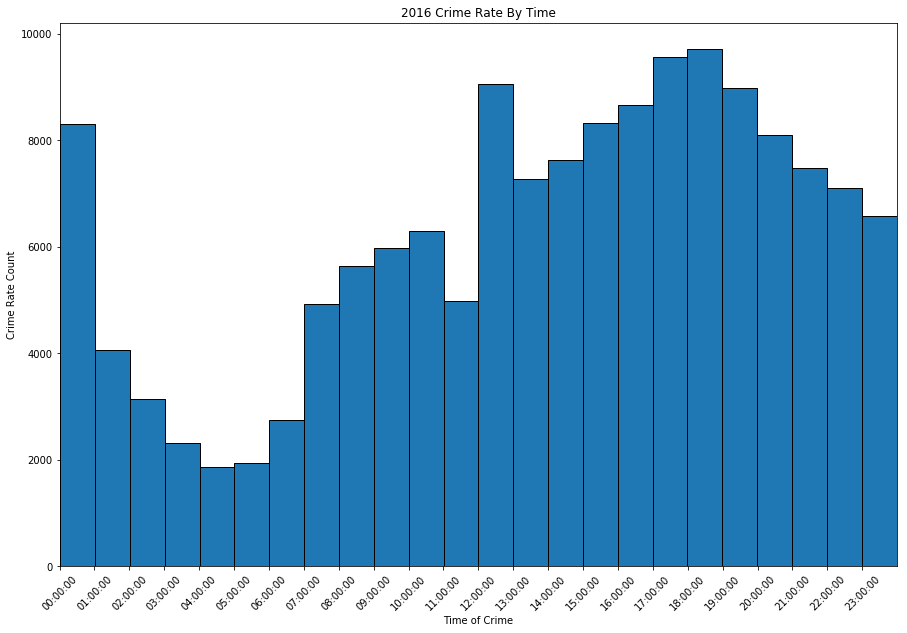

In [189]:
# Create histogram of Crime Rate
y, x, sf_hist = plt.hist(sf_time_list, bins=24, edgecolor="black")

hour_by_sec = []
for hour in range(24):
    hour_by_sec.append(hour * (60*60))

plt.title("2016 Crime Rate By Time")
plt.xlabel("Time of Crime")
plt.xlim([0, max(sf_time_list)])
plt.xticks(hour_by_sec, rotation = 45)
plt.ylabel("Crime Rate Count")
plt.show()

# Crime Rate by the Day (Year 2016)

In [190]:
def boolean_filter_col(dataset, target_name, col_name):
    """
        This function function uses boolean operations to extract the data you're trying to target
        Param: dataset     : DataFrame
               target_name : Str target
               col_name    : Dataframe series
        Return: Dataframe
    """
    target_filter = (dataset.loc[:, col_name] == target_name)
    temp_df = dataset[target_filter]
    
    return temp_df

In [191]:
def day_hist(dataset, list_name, col_name, title = "Crime"):
    
    for count, day in enumerate(list_name):
        temp_df = boolean_filter_col(dataset, day, col_name)
    
        #Assign SF DF time series into a list
        temp_time = list(temp_df['Time'])
        time_list = []

        # Formate time list and append to sf_time_list
        for x in temp_time:
            time_dt = datetime.strptime(x, '%H:%M')
            time_list.append(time_dt.time())

        plt.subplot(4,2,count+1)
        
        # Create histogram of Crime Rate
        plt.hist(time_list, bins=24, edgecolor='black', color="orange")

        hour_by_sec = []
        
        for hour in range(24):
            hour_by_sec.append(hour * (60*60))

        plt.title("{} Rate on {}".format(title, day))
        plt.xlabel("Time of Crime")
        plt.xlim([0, 86400])
        plt.xticks(hour_by_sec, rotation = 90)
        plt.ylabel("Crime Rate Count")
        plt.tight_layout()


    plt.show()   

In [192]:
# Create Dataframe with columns
sf_date = sf_data_2016[['DayOfWeek', 'Time']]

# Create list of names of days in week
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a catergorical list from day_list
sf_date['cat_days'] = pd.Categorical(sf_date['DayOfWeek'], categories=days_list, ordered=True)

# Sort your catergorical into a new data frame
temp_df = sf_date.sort_values('cat_days')

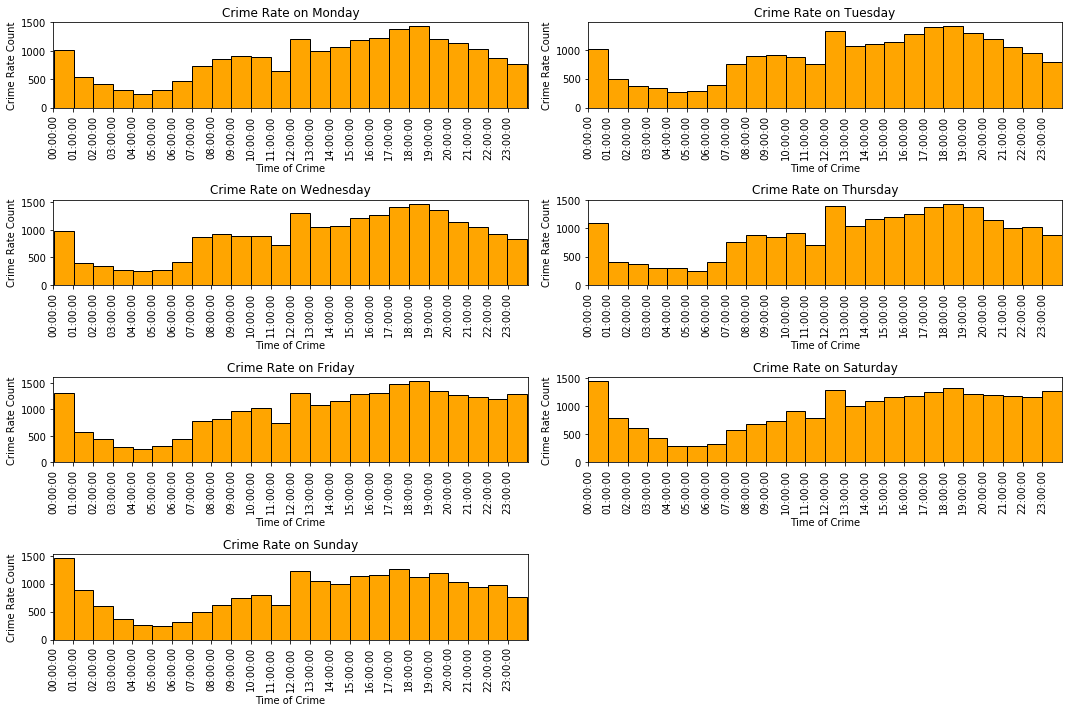

In [193]:
day_hist(temp_df, days_list, 'DayOfWeek')


# Frequency of Crime Types (Year 2016)

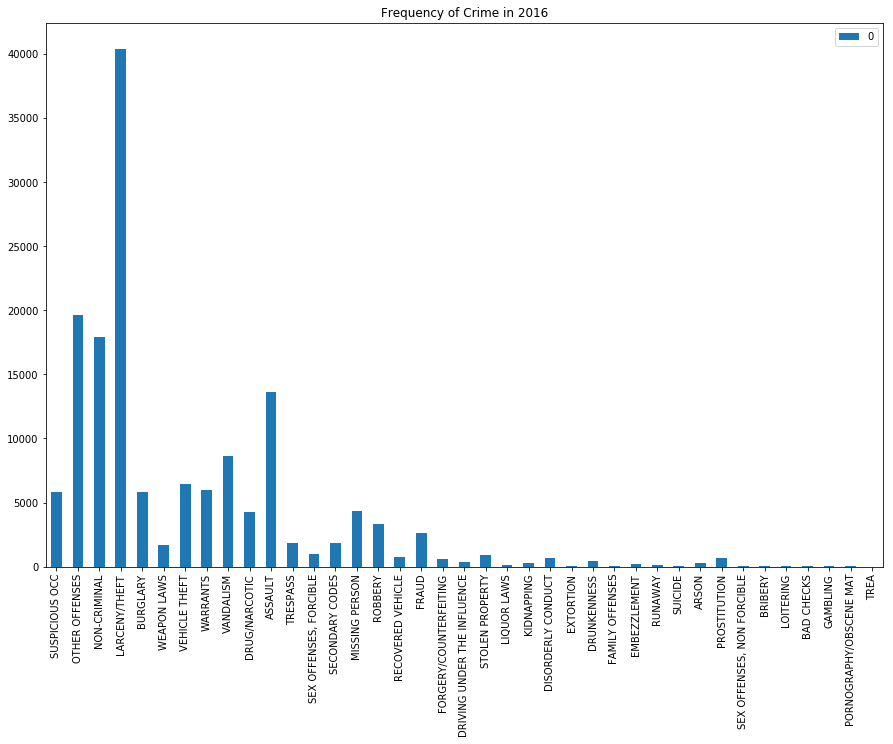

In [194]:
# Create counter dict using Category series
sf_crime_count = Counter(sf_data_2016['Category'])

# Plot out the types and frequency of crimes
df = pd.DataFrame.from_dict(sf_crime_count, orient='index')
df.plot(kind='bar', title='Frequency of Crime in 2016')

In [195]:
sf_crime_count.most_common(10)

[('LARCENY/THEFT', 40418),
 ('OTHER OFFENSES', 19649),
 ('NON-CRIMINAL', 17887),
 ('ASSAULT', 13593),
 ('VANDALISM', 8593),
 ('VEHICLE THEFT', 6420),
 ('WARRANTS', 5958),
 ('BURGLARY', 5806),
 ('SUSPICIOUS OCC', 5793),
 ('MISSING PERSON', 4343)]

# Examine Crimes with Respect to Time & Day
1. LARCENY/THEFT
2. ASSAULT
3. VANDALISM
4. VEHICLE THEFT
5. BURGLARY

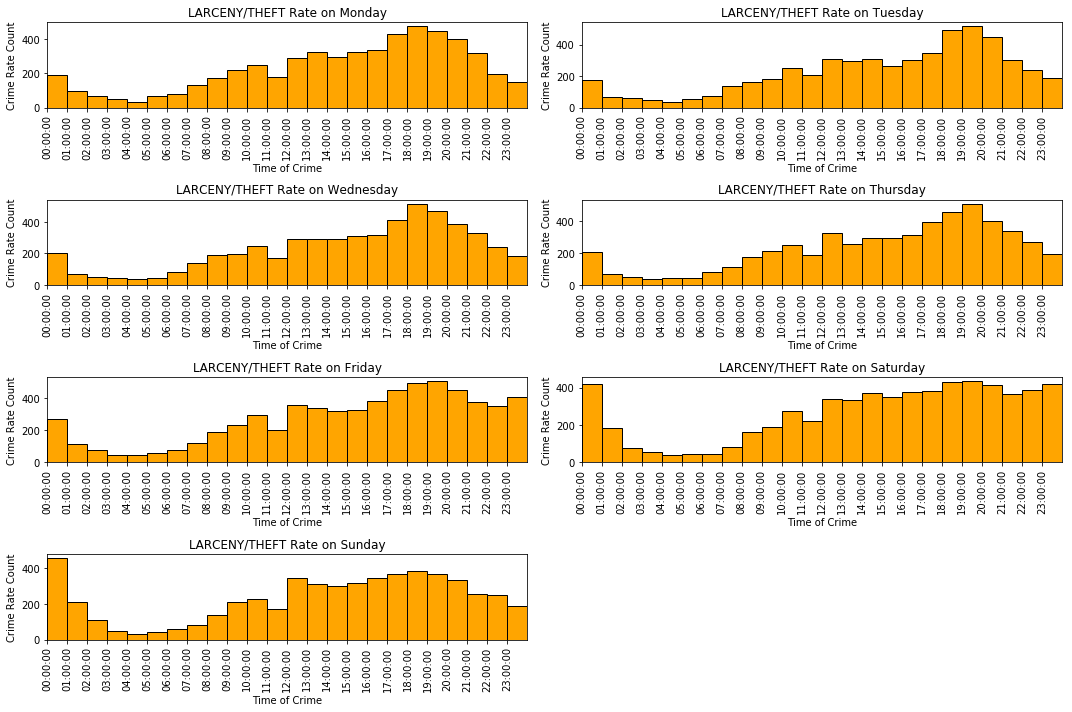

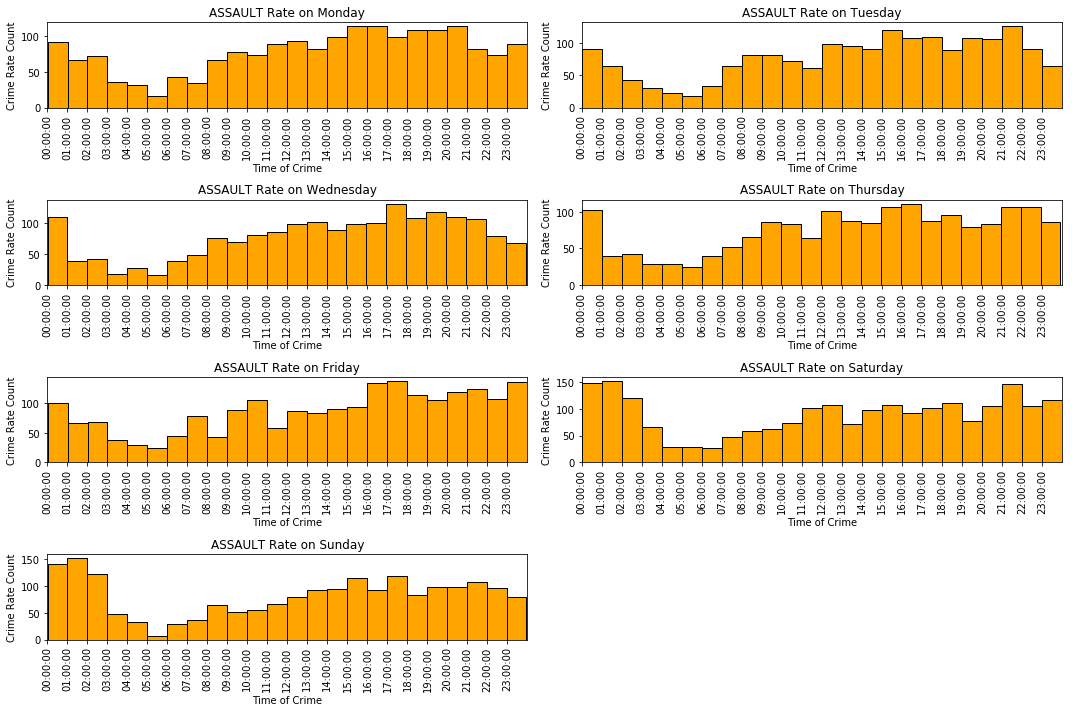

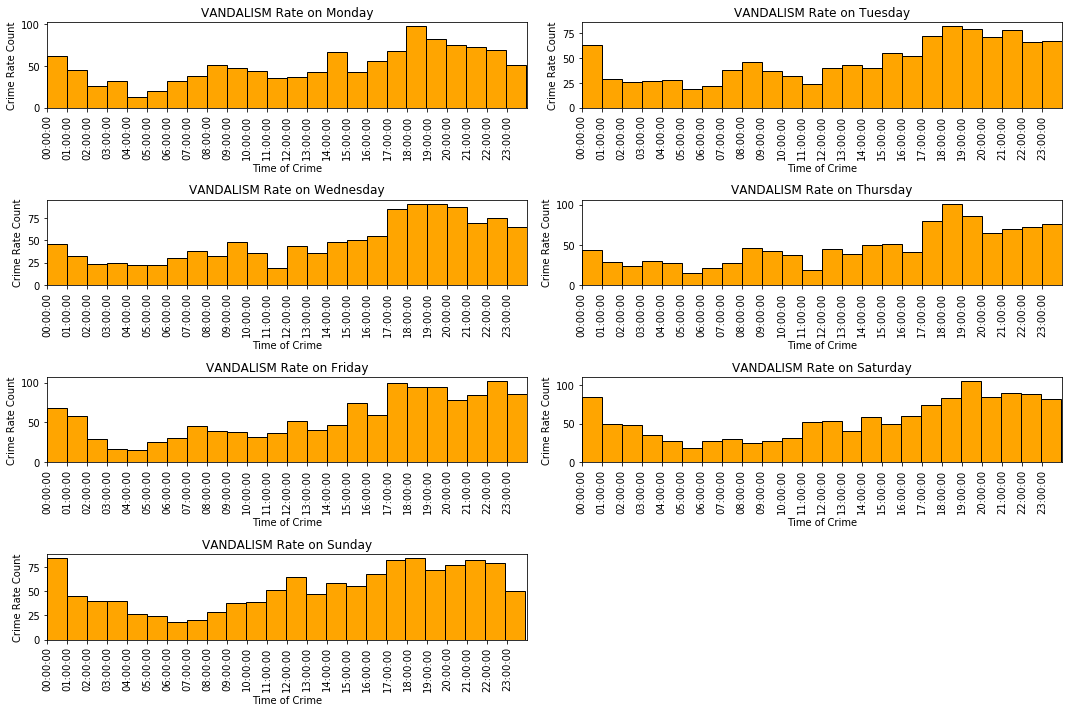

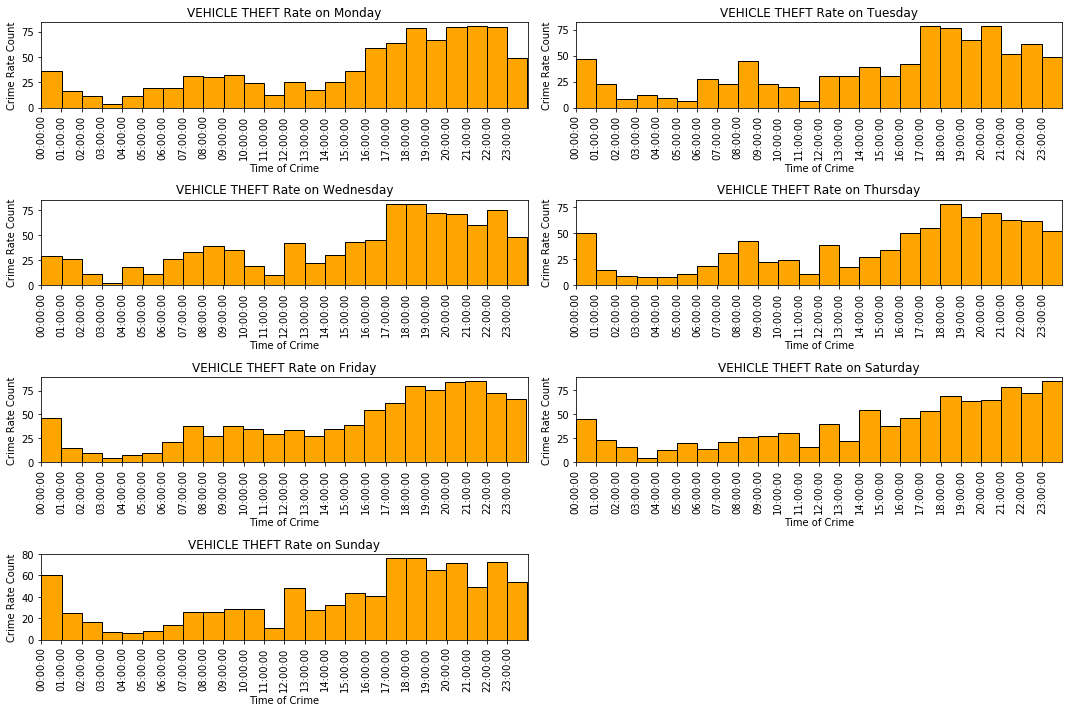

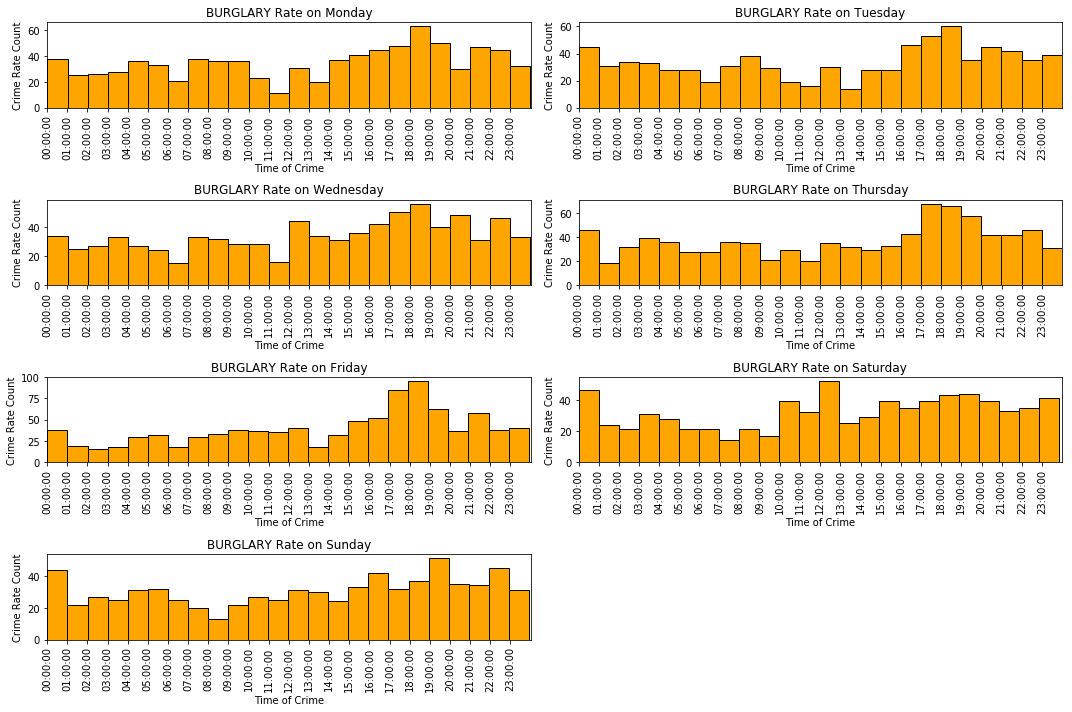

In [196]:
# Create target list
crime_list = ['LARCENY/THEFT', 'ASSAULT', 'VANDALISM', 'VEHICLE THEFT', 'BURGLARY']

# Create a df with a crime catergory column
crime_df = sf_data_2016[['DayOfWeek', 'Time', 'Category']]

# Create a catergorical list from day_list
crime_df['cat_days'] = pd.Categorical(crime_df['DayOfWeek'], categories=days_list, ordered=True)

# Sort your catergorical into a new data frame
crime_df = crime_df.sort_values('cat_days')

# day_hist(temp_df, crime_list, 'Category')

for x in range(len(crime_list)):
    temp_df = boolean_filter_col(crime_df, crime_list[x], 'Category')
    day_hist(temp_df, days_list, 'DayOfWeek', crime_list[x])

In [197]:
def convert_time(time):
    """
        This function converts a string obj to a datetime object.
        return: datetime
    """
    
    time = datetime.strptime(time, '%H:%M:%S')
    
    return time.time()

In [198]:
def timeframe_index(start_index, time_period):
    """
        This function will find the range for secitions of the day.
        return: cut off index
    """
    
    for count, time in enumerate(df['Time'][start_index:]):
        if(time >= time_period):
            return count

In [199]:
## Create heatmap from 12am-6am, 6am-12pm, 12pm-6pm, 6pm-12am

# Create dataframe
df = pd.DataFrame()

# Create Time & CrimeType columns
df['Time']     = pd.to_datetime(sf_data_2016['Time'], format='%H:%M').dt.time
df['Category'] = sf_data_2016['Category']
df['Location'] = sf_data_2016['Location']
df[['X', 'Y']] = sf_data_2016[['X', 'Y']]

# Sort by acending time
df = df.sort_values('Time')

# Convernt strings to datetime objects
morning   =  convert_time('6:00:00')
afternoon =  convert_time('12:00:00')
evening   =  convert_time('18:00:00')
midnight  =  convert_time('23:59:59')

# Find the range to use for spliting up dataframe
midnight_morning   = timeframe_index(0, morning)
morning_afternoon  = timeframe_index(midnight_morning, afternoon)
afternoon_evening  = timeframe_index(morning_afternoon, evening)
evening_midnight   = len(df)

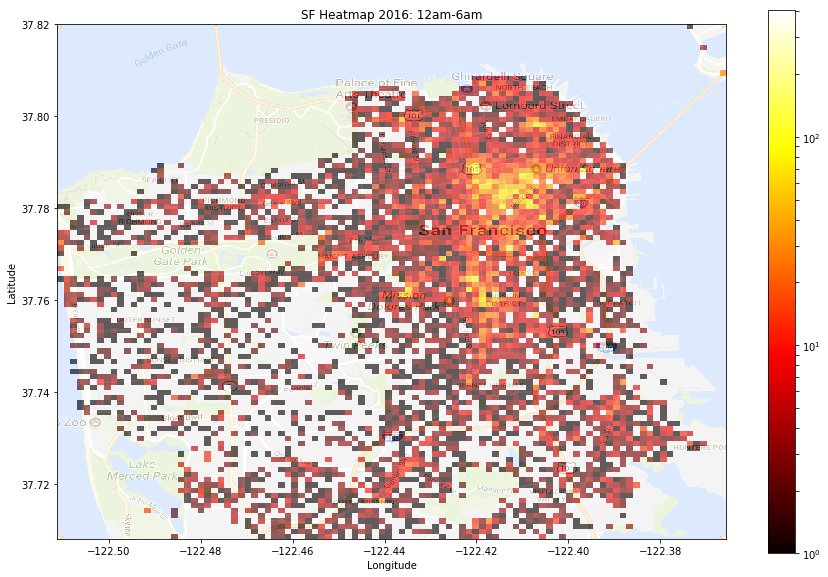

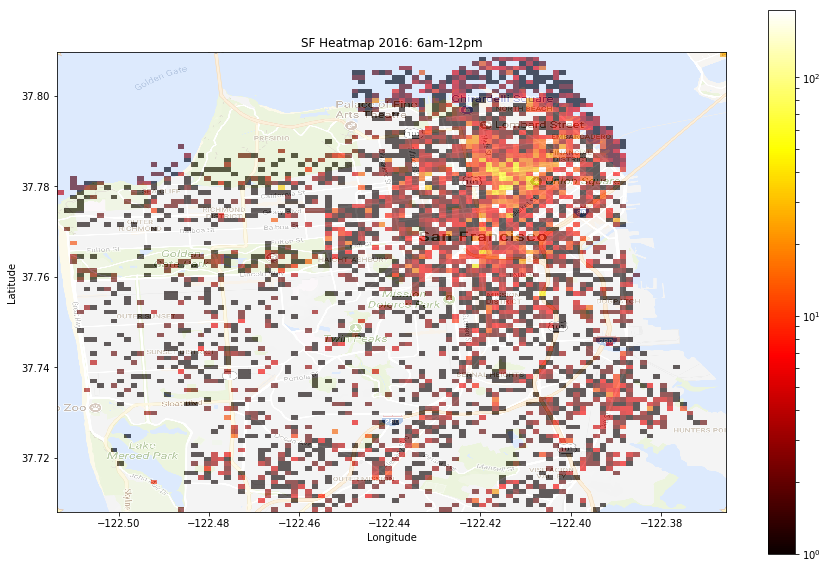

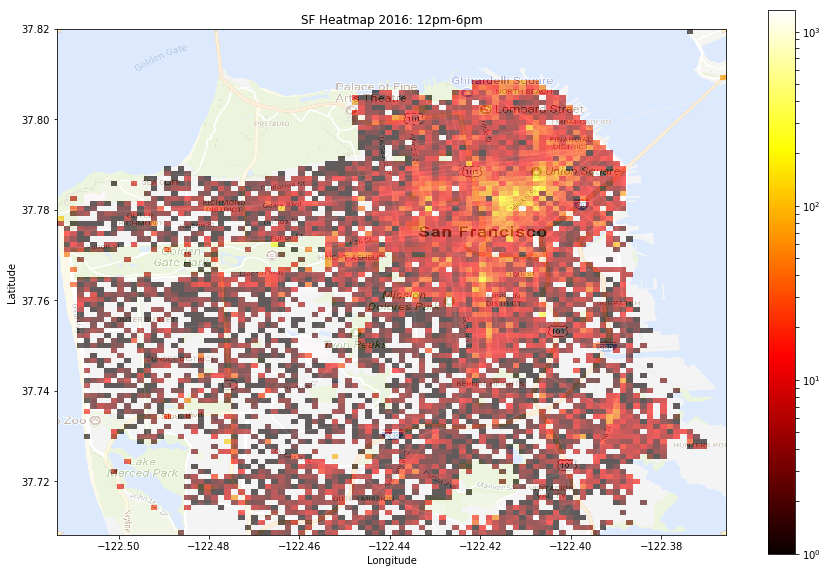

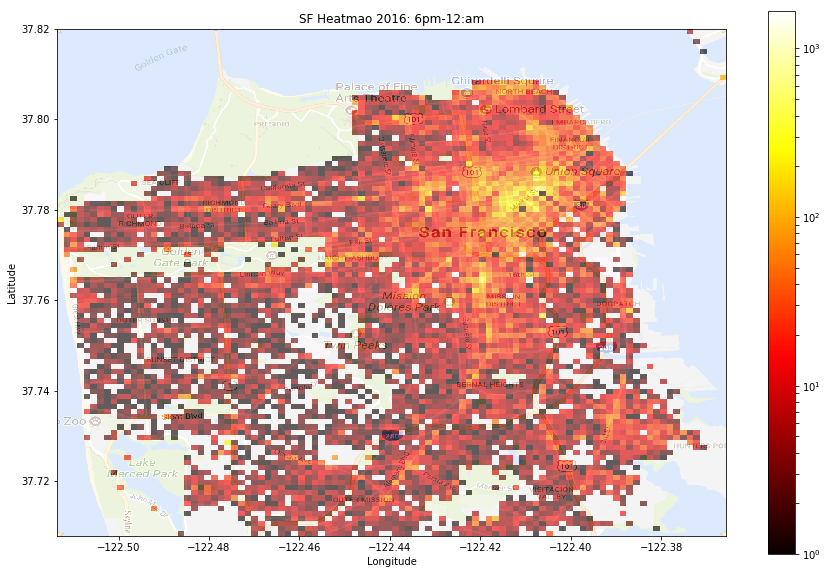

In [200]:
generate_heatmap(df[0                 : midnight_morning] , "SF Heatmap 2016: 12am-6am")
generate_heatmap(df[midnight_morning  : morning_afternoon], "SF Heatmap 2016: 6am-12pm")
generate_heatmap(df[morning_afternoon : afternoon_evening], "SF Heatmap 2016: 12pm-6pm")
generate_heatmap(df[afternoon_evening : evening_midnight] , "SF Heatmao 2016: 6pm-12:am")

In [201]:
## Find out if crime is increasing throughout the year

# create new dataframe
df = pd.DataFrame()

# assign date column datatime objects
df['Date'] = pd.to_datetime(sf_data_2016['Date'])

# sort by date
df = df.sort_values('Date')

In [202]:
count = 0
target = 1
month_list = []

for x in df['Date']:
    if(x.month == target):
        count += 1
    elif(target == 13):
        break
    else:
        month_list.append(count)
        count = 0
        target += 1

month_list.append(count)

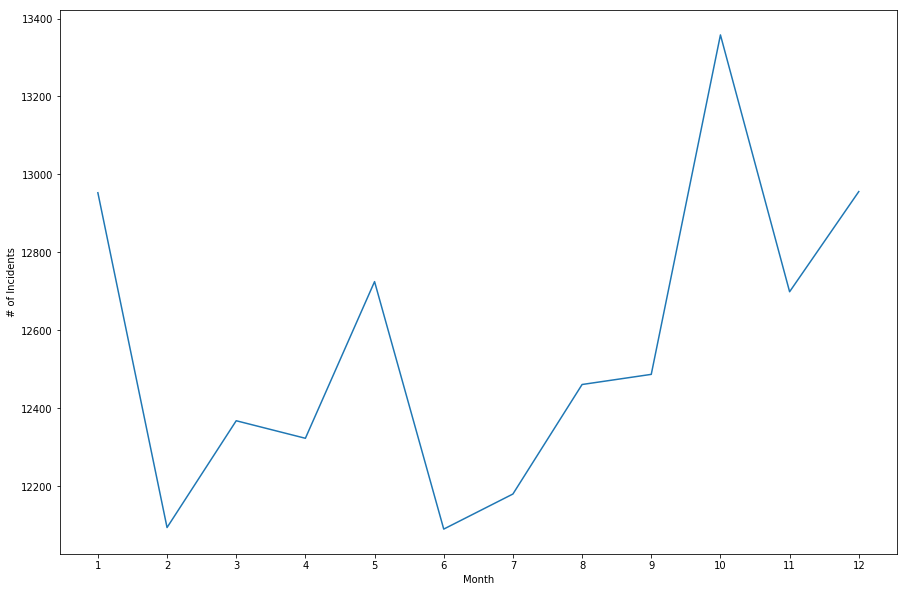

In [203]:
plt.plot(month_list)
plt.xticks(range(12), range(1,13))
plt.xlabel('Month')
plt.ylabel('# of Incidents')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'toordinal'

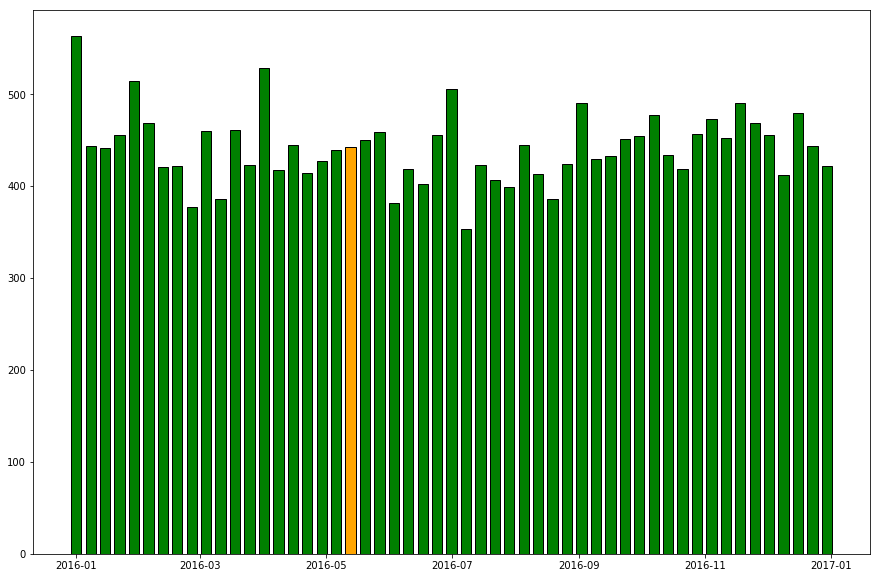

In [204]:
test = sf_data_2016.loc[sf_data_2016['DayOfWeek'] == 'Friday']
test = test.sort_values('Date')
test_count = Counter(test['Date'])

test_count = pd.DataFrame.from_dict(test_count, orient='index')
test_count.columns = ['Count']

colors = []
x_label_names = []

for date in test_count.index:
    if date.day == 13:
        colors.append('orange')
    else:
        colors.append('green')     

    x_label_names.append(str(date.date()))

plt.bar(test_count.index, test_count['Count'], edgecolor='black', color=colors, width=5)
plt.xticks(test_list, rotation=45)
plt.show()


In [ ]:
barlist = test_count.plot(kind='bar', title='Friday the 13th Crime Count', width=1, color=colors, edgecolor='black')
barlist.set_xticklabels(test_count.index.format())
plt.show()